# MAG Recommendation

In [1]:
import snap
from IPython.display import Image
from collections import defaultdict
import operator
from bfs_graph import translate, create_snap_graph, get_bfs_graph
from mag_api import mag_evaluate, mag_get_title, mag_get_date

## Create BFS Subgraph
Retrieve the graph produced by a BFS from the given start paper.

In [2]:
G, mag_to_snap = get_bfs_graph(2366141641, 2, True, False)
snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}

Starting from 2366141641 and searcher for 2 levels (follow out: true, follow in: false)

Found 1395 nodes, 1684 edges and output edge list to 2366141641.txt


In [4]:
# Sanity check for correct nodes and ID translation.
for node in G.Nodes():
    print node.GetId(), "\t", snap_to_mag[node.GetId()]

0 	2136040699
1 	2133753659
2 	2134262590
3 	2141361171
4 	1985809919
5 	2023717039
6 	2177287823
7 	1482977908
8 	2034266583
9 	1966347620
10 	2102544846
11 	2154357715
12 	2155467226
13 	2006793117
14 	2053186076
15 	2098693229
16 	2121647436
17 	2135346934
18 	2153763188
19 	1578099820
20 	2097366995
21 	2156718197
22 	2001141328
23 	2124925761
24 	2148694408
25 	2062104878
26 	2108995755
27 	1492310998
28 	1770825568
29 	2095948001
30 	2117553576
31 	2130278361
32 	2611015177
33 	143632740
34 	164484921
35 	2782823532
36 	2101699902
37 	2107023570
38 	2110935301
39 	2129018774
40 	2145121236
41 	2169779569
42 	1500063156
43 	2115096495
44 	2147717514
45 	2154454189
46 	2163032501
47 	2408612350
48 	2100495367
49 	2148847267
50 	2136583165
51 	2007321142
52 	2026417691
53 	2102716594
54 	2116064496
55 	2147010501
56 	66838807
57 	2153579005
58 	2171928131
59 	1965154800
60 	2132339004
61 	2138204974
62 	2117130368
63 	2120861206
64 	2131462252
65 	2141599568
66 	1614298861
67 	16621

586 	2097973429
587 	1972156947
588 	2119384858
589 	2119825970
590 	2420733993
591 	2070996757
592 	2100235073
593 	2060204748
594 	1490256991
595 	2138180870
596 	140434194
597 	2054553473
598 	2001325956
599 	2136979193
600 	23149702
601 	2032280284
602 	2145453687
603 	2149169025
604 	2611832198
605 	1616338336
606 	1976969221
607 	2122838776
608 	2121727356
609 	59935691
610 	1492581097
611 	1998839399
612 	2062179223
613 	2171810970
614 	2798357086
615 	2111708605
616 	2115893150
617 	2129620481
618 	2163302275
619 	1482501784
620 	2102931907
621 	2341172467
622 	1482680420
623 	2071399839
624 	2090571400
625 	2161172169
626 	2166096645
627 	2798807981
628 	1971421925
629 	2117495845
630 	2141499038
631 	2108718322
632 	2768317741
633 	1556758605
634 	2027545174
635 	2066636486
636 	2107481077
637 	2121639104
638 	2155048531
639 	2614412583
640 	2117831564
641 	2145845082
642 	60965852
643 	2069153192
644 	2148606196
645 	2160053408
646 	2053906518
647 	2101246646
648 	2112090702

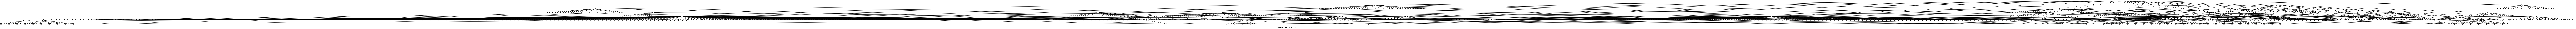

In [5]:
snap.DrawGViz(G, snap.gvlDot, "2366141641.png", "BFS Graph for 2366141641 (Out)")
Image(filename='2366141641.png')

In [6]:
Graph, mag_to_snap_full = get_bfs_graph(633000, 3, True, True)
snap_to_mag_full = {v: k for k, v in mag_to_snap_full.iteritems()}

Starting from 633000 and searcher for 3 levels (follow out: true, follow in: true)

Found 6443 nodes, 7053 edges and output edge list to 633000.txt


In [11]:
# Sanity check
start_node = Graph.GetNI(mag_to_snap_full[633000])
print("633000 has {} references in full BFS graph".format(start_node.GetOutDeg()))
print("633000 has {} citations in full BFS graph".format(start_node.GetInDeg()))

633000 has 4 references in full BFS graph
633000 has 2 citations in full BFS graph


## MAG Request

In [9]:
mag_get_title(2366141641)

'node2vec scalable feature learning for networks (2016)'

## Search Path Count

In [3]:
def get_in_degrees(Graph):
    InDegV = snap.TIntPrV()
    snap.GetNodeInDegV(Graph, InDegV)
    return {item.GetVal1() : item.GetVal2() for item in InDegV}

def get_out_degrees(Graph):
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(Graph, OutDegV)
    return {item.GetVal1() : item.GetVal2() for item in OutDegV}

In [4]:
def compute_n_minus(start, in_degrees, Graph):
    n_minus = defaultdict(int)
    in_deg = in_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        # print "looking at node", node
        if in_degrees[node] == 0:
            n_minus[node] = 1
        else:
            total = 0
            for citation in Graph.GetNI(node).GetInEdges():
                total += n_minus[citation]
            n_minus[node] = total

        for ref in Graph.GetNI(node).GetOutEdges():
            in_deg[ref] -= 1
            if in_deg[ref] == 0:
                start.add(ref)
                # print "... added", ref
            # else:
                #print "... skipping", ref, "still has ", in_deg[ref], " in edges"
                #print "......", list(Graph.GetNI(ref).GetInEdges())
    return n_minus

In [5]:
def compute_n_plus(start, out_degrees, Graph):
    n_plus = defaultdict(int)
    out_deg = out_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        if out_degrees[node] == 0:
            n_plus[node] = 1
        else:
            total = 0
            for reference in Graph.GetNI(node).GetOutEdges():
                total += n_plus[reference]
            n_plus[node] = total

        for citation in Graph.GetNI(node).GetInEdges():
            out_deg[citation] -= 1
            if out_deg[citation] == 0:
                start.add(citation)
    return n_plus

In [6]:
def spc(Graph):
    in_degrees = get_in_degrees(Graph)
    out_degrees = get_out_degrees(Graph)
    
    n_minus = compute_n_minus(set([node for node in in_degrees if in_degrees[node] == 0]), in_degrees, Graph)
    n_plus = compute_n_plus(set([node for node in out_degrees if out_degrees[node] == 0]), out_degrees, Graph)
    
    spc_counts = defaultdict(int)
    for edge in Graph.Edges():
        src = edge.GetSrcNId()
        dst = edge.GetDstNId()
        spc_counts[(src, dst)] = n_minus[src] * n_plus[dst]
    return spc_counts

## Main Path Analysis

In [7]:
def mpa(start_node, translate, Graph):
    spc_counts = spc(Graph)
    node = start_node
    print mag_get_title(translate[node])
    while Graph.GetNI(node).GetOutDeg() != 0:
        next_node = -1
        largest_spc = -1
        for neighbor in Graph.GetNI(node).GetOutEdges():
            if spc_counts[(node, neighbor)] > largest_spc:
                largest_spc = spc_counts[(node, neighbor)]
                next_node = neighbor
        node = next_node
        print "-", largest_spc, "->", mag_get_title(translate[node])

## Get Foundations Function (Final)

In [8]:
def validate_graph(Graph, snap_to_mag):
    bad_edges = set()
    for edge in Graph.Edges():
        src_nid = edge.GetSrcNId()
        dst_nid = edge.GetDstNId()
        if Graph.IsEdge(dst_nid, src_nid):
            first = min(src_nid, dst_nid)
            second = max(src_nid, dst_nid)
            bad_edges.add((first, second))
    for bad_edge in bad_edges:
        date1 = mag_get_date(snap_to_mag[bad_edge[0]])
        date2 = mag_get_date(snap_to_mag[bad_edge[1]])
        if date1 < date2:
            print "Deleting edge (%d, %d)" % (snap_to_mag[bad_edge[1]], snap_to_mag[bad_edge[0]])
            Graph.DelEdge(bad_edge[1], bad_edge[0])
        else:
            print "Deleting edge (%d, %d)" % (snap_to_mag[bad_edge[0]], snap_to_mag[bad_edge[1]])
            Graph.DelEdge(bad_edge[0], bad_edge[1])

In [9]:
def get_foundations(paper, levels=2, follow_out=True, follow_in=False):
    Graph, mag_to_snap = get_bfs_graph(paper, levels, follow_out, follow_in)
    snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}
    validate_graph(Graph, snap_to_mag)
    print '='*10
    print "RESULTS:"
    mpa(mag_to_snap[paper], snap_to_mag, Graph)

In [10]:
get_foundations(633000, 3, True, True)

Starting from 633000 and searcher for 3 levels (follow out: true, follow in: true)

Found 6443 nodes, 7053 edges and output edge list to 633000.txt
Deleting edge (2116295480, 1542975199)
Deleting edge (2752701825, 1814609616)
Deleting edge (2111796094, 2818398795)
Deleting edge (2111796094, 2221058875)
Deleting edge (1814609616, 1569054875)
Deleting edge (2298149297, 2212104334)
Deleting edge (1546496099, 1814609616)
Deleting edge (1652477863, 1949961416)
Deleting edge (1814609616, 2284674511)
Deleting edge (2111796094, 2868008041)
Deleting edge (2111796094, 2414514734)
Deleting edge (1814609616, 2244532750)
Deleting edge (2212104334, 2403742663)
Deleting edge (1495720156, 1597515498)
Deleting edge (1525052678, 1495720156)
Deleting edge (2279976466, 1495720156)
Deleting edge (1500604586, 1814609616)
Deleting edge (1950561015, 2255748008)
Deleting edge (1495720156, 2244096845)
Deleting edge (1522735595, 1495720156)
Deleting edge (2111796094, 2257422111)
Deleting edge (1526302566, 151289

In [11]:
get_foundations(2366141641, 2, True, False)

Starting from 2366141641 and searcher for 2 levels (follow out: true, follow in: false)

Found 1395 nodes, 1684 edges and output edge list to 2366141641.txt
RESULTS:
node2vec scalable feature learning for networks (2016)
- 2230 -> grarep learning graph representations with global structural information (2015)
- 1010 -> line large scale information network embedding (2015)
- 1336 -> deepwalk online learning of social representations (2014)
- 1710 -> representation learning a review and new perspectives (2013)
- 198 -> a global geometric framework for nonlinear dimensionality reduction (2000)
- 23 -> independent component analysis a new concept (1994)


In [20]:
get_foundations(2139694940, 2, True, False)

Starting from 2139694940 and searcher for 2 levels (follow out: true, follow in: false)

Found 1536 nodes, 2205 edges and output edge list to 2139694940.txt
Deleting edge (2050239729, 2068015060)
Deleting edge (2726858191, 2146591355)
Deleting edge (2022704179, 2139694940)
Deleting edge (2127048411, 2146591355)
RESULTS:
overlapping community detection at scale a nonnegative matrix factorization approach (2013)
- 21542 -> community affiliation graph model for overlapping network community detection (2012)
- 0 -> community detection in graphs (2010)
- 0 -> fast unfolding of communities in large networks (2008)


## Baselines

### Number of Citations

In [26]:
def citations(paper, snap_to_mag, Graph):
    InDegV = snap.TIntPrV()
    snap.GetNodeInDegV(Graph, InDegV)
    in_degrees = [(snap_to_mag[item.GetVal1()], item.GetVal2()) for item in InDegV]
    in_degrees.sort(key=operator.itemgetter(1), reverse=True)
    print "PAPERS WITH MOST CITATIONS RESULTS:"
    for a in in_degrees[:6]:
        print mag_get_title(a[0])

### PageRank

In [27]:
def pagerank(paper, snap_to_mag, Graph):
    PRankH = snap.TIntFltH()
    snap.GetPageRank(Graph, PRankH)
    PRankH.SortByDat(False)
    pagerank_scores = [(snap_to_mag[item], PRankH[item]) for item in PRankH]
    print "PAGERANK RESULTS:"
    for a in pagerank_scores[:6]:
        print mag_get_title(a[0])

### Hubs and Authorities

In [28]:
def hits(paper, snap_to_mag, Graph):
    NIdHubH = snap.TIntFltH()
    NIdAuthH = snap.TIntFltH()
    snap.GetHits(Graph, NIdHubH, NIdAuthH)
    NIdHubH.SortByDat(False)
    NIdAuthH.SortByDat(False)

    hub_scores = [(snap_to_mag[item], NIdHubH[item]) for item in NIdHubH]
    authority_scores = [(snap_to_mag[item], NIdAuthH[item]) for item in NIdAuthH]
    print "TOP HUBS:"
    for a in hub_scores[:6]:
        print mag_get_title(a[0])

    print "TOP AUTHORITIES:"
    for a in authority_scores[:6]:
        print mag_get_title(a[0])

## Compare Results Function

In [29]:
def compare_results(paper, levels=2, follow_out=True, follow_in=False):
    Graph, mag_to_snap = get_bfs_graph(paper, levels, follow_out, follow_in)
    snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}
    validate_graph(Graph, snap_to_mag)
    print '='*10
    print "MAG RESULTS:"
    mpa(mag_to_snap[paper], snap_to_mag, Graph)
    print '='*10
    citations(mag_to_snap[paper], snap_to_mag, Graph)
    print '='*10
    pagerank(mag_to_snap[paper], snap_to_mag, Graph)
    print '='*10
    hits(mag_to_snap[paper], snap_to_mag, Graph)

In [30]:
compare_results(2366141641, 2, True, False)

Starting from 2366141641 and searcher for 2 levels (follow out: true, follow in: false)

Found 1395 nodes, 1684 edges and output edge list to 2366141641.txt
MAG RESULTS:
node2vec scalable feature learning for networks (2016)
- 2230 -> grarep learning graph representations with global structural information (2015)
- 1010 -> line large scale information network embedding (2015)
- 1336 -> deepwalk online learning of social representations (2014)
- 1710 -> representation learning a review and new perspectives (2013)
- 198 -> a global geometric framework for nonlinear dimensionality reduction (2000)
- 23 -> independent component analysis a new concept (1994)
PAPERS WITH MOST CITATIONS RESULTS:
nonlinear dimensionality reduction by locally linear embedding (2000)
a global geometric framework for nonlinear dimensionality reduction (2000)
reducing the dimensionality of data with neural networks (2006)
the link prediction problem for social networks (2007)
friends and neighbors on the web (2003